In [1]:
# -----------------------
# Trace out the bifurcations for a given number of
# bounces where energy starts at -1/3. When a
# bifurcation is found, trace it out using a vector
# and varying p_phi
# -----------------------

# Import needed libraries
import magphyxp
import numpy as np
import sys
import queue

In [2]:
# -----------------------
# Variables deciding whether
# pphi is constant or ptheta
# is constant
VARY_PTHETA_PPHI = 0
VARY_PTHETA_ENERGY = 1
# -----------------------

def get_pphi_max(E, ptheta):
    x = (E + 1/3 - ptheta**2 / 2) / 5
    if x < 0:
        return -1
    return np.sqrt(x)

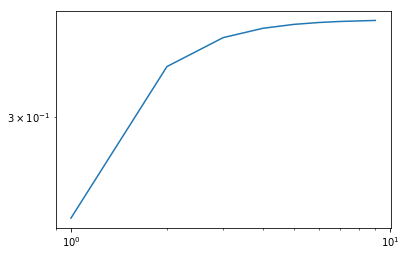

In [29]:
from matplotlib import pyplot as plt
import seaborn as sns

E = [-.0646, -.0166, -.00651, -.00318, -.00178, -.001099, -.000724, -.000362]
E = [e+1/3 for e in E]
m = [1, 2, 3, 4, 5, 6, 7, 9]
plt.plot(m, E)
plt.yscale('log')
plt.xscale('log')


In [60]:
def trace_mode(curr_state, mode_id):
    VECTOR_FACTOR = 1.1
    states = []#curr_state]
    # Used in determining if the energy is increasing within some margin
    epsilon = 1e-2
    #vector = np.array((0, V_STEP, 0)) # Setup vector
    vector = np.array((curr_state[0], curr_state[1], 0)) # Setup vector
    vector = vector*1e6
    #vector = np.array((V_STEP, V_STEP, 0)) # Setup vector
    new_bifurcation = True
    while (curr_state[2] < 0):
        next_state = curr_state + vector # Follow the vector to next state
        prev_state = next_state # Save state where we came from
        pphi_max = get_pphi_max(next_state[2], next_state[0])
        if (pphi_max < 0 or next_state[1] > pphi_max or next_state[2] > 0):
            #print('break 1.2')
            break
        # Calculate new min at new location
        min_two = magphyxp.calculate_min(next_state[0], next_state[1], num_bounces, next_state[2], 1e-7,
                                         VARY_PTHETA_ENERGY, 1e-7) 
        if min_two.f > 1e-9:
            #print('break 2: f={}'.format(min_two.f))
            break
        next_state = np.array((min_two.ptheta, min_two.pphi, min_two.energy)) # New min gives new state

        # Find new vector
        vector = next_state - curr_state

        curr_state = next_state # Change current state to the newest one found
        if (next_state[2] < (prev_state[2] - epsilon)): # Make sure energy is increasing within some tolerance
            #print('break 3')
            break
        # Write out ID, N, pr, ptheta, pphi, energy, rocking number, in phase, period
        #if new_bifurcation:
        #    new_bifurcation = False
        #    mode_id += 1
        state = {
            'mode_id' : mode_id,
            'num_bounces' : num_bounces,
            'pr' : np.sqrt(abs(2*curr_state[2] + 2/3 - curr_state[0]**2 - 10*curr_state[1]**2)),
            'ptheta' : curr_state[0],
            'pphi' : curr_state[1],
            'energy' : curr_state[2],
            #'rocking_number' : int(min_two.rocking_number / 2),
            'rocking_number' : min_two.rocking_number,
            'in_phase' : min_two.rocking_in_phase,
            'period' : min_two.t
        }
        states.append(state)
        # Slowly increase the step size of the vector
        vector[1] *= VECTOR_FACTOR
        vector[2] *= VECTOR_FACTOR
        # -------------------------------------------
        epsilon *= 0.9 # Slowly decrease tolerance of energy difference
    return states

In [116]:
import math

def search_forward(rocking_number, m_found):
    if rocking_number >= len(m_found) - 1:
        return False
    return not m_found[rocking_number+1]

def search_backward(rocking_number, m_found):
    return rocking_number > 0 and not m_found[rocking_number-1]


class BifLoc:
    def __init__(self, E, m):
        self.E = E
        self.m = m

# Does a binary search to find where E belongs in the bifurcation locations.
# If the region is surrounded by two found bifurcations such that the
# rocking numbers are next to each other, then the region is empty.
# m_max is the maximum rocking number we're going to allow.
def is_empty(E, bif_locs, m_max):
    if E == 0:
        return True
    i = 0
    j = len(bif_locs)
    while j-i > 1:
        k = (i+j)//2
        if bif_locs[k].E <= E:
            i = k
        else:
            j = k
    if bif_locs[i].m == bif_locs[j].m-1 or bif_locs[i].m == m_max:
        return True
    return False

#bif_locs = [BifLoc(-1/3, 0), BifLoc(-.22, 3),
#            BifLoc(-.1, 4), BifLoc(0, math.inf)]
#bif_locs[-1].E
#print(is_empty(-.2, bif_locs, 4))

# found_m is a list of booleans with the rocking numbers that we have found.
# bif_locs is an array storing where bifurcations (described using their
# rocking number) are located. For example, if we've found bifurcations
# m=3 and m=4:
#
#      0      3                 4     inf
#      |------|-----------------|------|
#     -.3    -.23             -.14     0
#
# The data structure is a list of tuples (E,m):
# (-.3, 0)  (-.23, 3)  (-.14, 4)  (0, inf)
def find_mode_bsearch(num_bounces, min_E_0, max_E_0, m_found, bif_locs, m_max):
#    global previous_E
    global bifurcation_id

    Q = queue.Queue()
    Q.put((min_E_0, max_E_0))

    while not Q.empty():
        (min_E, max_E) = Q.get()

        E = (min_E + max_E) / 2
#         print('testing ({:.5f}, {:.5f})'.format(min_E, max_E));

        # Do a binary search in bif_locs to see if our region has
        # any bifurcations to find.
        if is_empty(E, bif_locs, m_max):
            continue

        mode_found = False

#         print('searching ({:.5f}, {:.5f})'.format(min_E, max_E));

        # Calculate minimum
        bifurcation_state = magphyxp.calculate_min(
            PTHETA_0, PPHI_0, num_bounces, E, 1e-7,
            VARY_PTHETA_ENERGY, 1e-7)

        bifurcation_E = 1
        pphi_max = get_pphi_max(bifurcation_state.energy, bifurcation_state.ptheta)
        if (bifurcation_state.f < 1e-9 and bifurcation_state.energy > -1/3
    #        and bifurcation_state.energy - previous_E > E_step
            and V_STEP < pphi_max
            # duplicate state
            # and (bifurcation_state.rocking_number % num_bounces) > 0
            and bifurcation_state.t > 0.0):

            # Get the current state of pphi, ptheta, and energy
            curr_state = np.array((bifurcation_state.ptheta,
                                   bifurcation_state.pphi,
                                   bifurcation_state.energy))
            bifurcation_E = bifurcation_state.energy

            states = trace_mode(curr_state, bifurcation_id)

            # We sometimes get phantom modes that have a low f value.
            # This especially occurs at low energy since the free magnet is moving
            # very little. To ensure that these don't get reported as true modes
            # we go ahead and trace the mode as far as it goes and then test if it
            # reached a value of pphi above a threshold. Keep the mode only if it
            # reaches the threshold.
            if states[-1]['pphi'] > 1e-3:
                mode_found = True

                # Get the rocking number from the last state as it is more
                # reliable (less risk of numerical error).
                rocking_number = states[-1]['rocking_number']
                # Get the energy at which the bifurcation occurs.
                bif_E = states[0]['energy']

#                 print('found: m={}, E={:.4f}'.format(rocking_number, bif_E))
                # If the rocking number m has already been found, look in the
                # opposite direction
                #    case 1:
                #    min_E      m          E                    max_E
                #      |--------|----------|----------------------|
                #                          |----------------------|
                #                                 look here
                #    case 2:
                #    min_E                 E     m              max_E
                #      |-------------------|-----|----------------|
                #      |-------------------|
                #          look here
                if rocking_number >= len(m_found):
#                     print('Out of bounds. Searching backward')
                    # search backward
                    Q.put((min_E, bif_E))
#                     find_mode(num_bounces, min_E, E, m_found)
                else:
                    if not m_found[rocking_number]:
#                         print('found: m={}'.format(rocking_number))
                        print('{:<3d} '.format(rocking_number), end='', flush=True)
#                         print('not found. inserting')
                        # insert everything
                        m_found[rocking_number] = True
                        idx = 0
                        while bif_locs[idx].m < rocking_number:
                            idx = idx+1
                        bif_locs.insert(idx, BifLoc(bif_E, rocking_number))
                        
                        for state in states:
                            f.write(
                                '{} {} {:<.5e} {:<.5e} {:<.5e} {:<.5e} {} {} {:<.5f}\n'.format(
                                    state['mode_id'], state['num_bounces'], state['pr'],
                                    state['ptheta'], state['pphi'],
                                    state['energy'], state['rocking_number'], state['in_phase'], state['period'])
                            )

                        f.flush()
                        bifurcation_id += 1
                    
                    # "recursive" calls
#                     print('recursive calls')
                    if bif_E < E:
                        if bif_E <= min_E:
                            Q.put((E, max_E))
                        else:
                            Q.put((min_E, bif_E))
                            Q.put((E, max_E))
                    else:
                        if bif_E >= max_E:
                            Q.put((min_E, E))
                        else:
                            Q.put((min_E, E))
                            Q.put((bif_E, max_E))
                    
        if not mode_found:
            # "recursive" calls
            Q.put((min_E, E))
            Q.put((E, max_E))
#             find_mode(num_bounces, E, max_E, m_found)
#             find_mode(num_bounces, min_E, E, m_found)
  

In [ ]:
# def

In [128]:
T_THRESHOLD = 350000

def find_mode_step(num_bounces, E):
    global previous_E
    global bifurcation_id

    # Calculate minimum
    bifurcation_state = magphyxp.calculate_min(PTHETA_0, PPHI_0, num_bounces, E, 1e-7,
                                               VARY_PTHETA_ENERGY, 1e-7)

    bifurcation_E = 1
    pphi_max = get_pphi_max(bifurcation_state.energy, bifurcation_state.ptheta)
    if (bifurcation_state.f < 1e-9 and bifurcation_state.energy > -1/3
        and bifurcation_state.energy - previous_E > E_step
        and V_STEP < pphi_max
#         and (bifurcation_state.rocking_number % num_bounces) > 0 # duplicate state
        and bifurcation_state.t > 0.0):
        # Get the current state of pphi, ptheta, and energy
        curr_state = np.array((bifurcation_state.ptheta, bifurcation_state.pphi, bifurcation_state.energy))
        bifurcation_E = bifurcation_state.energy

        states = trace_mode(curr_state, bifurcation_id)

        # We sometimes get phantom modes that have a low f value. This especially
        # occurs at low energy since the free magnet is moving very little. To ensure
        # that these don't get reported as true modes we go ahead and trace the mode
        # as far as it goes and then test if it reached a value of pphi above a threshold.
        # Keep the mode only if it reaches the threshold.
        if len(states) > 0 and states[-1]['pphi'] > 1e-3:
            rocking_number = states[-1]['rocking_number']
            print('{:<3d} '.format(rocking_number), end='', flush=True)
            for state in states:
                f.write(
                    #'{} {} {:<.5f} {:<.5f} {:<.5f} {:<.5f} {} {} {:<.5f}\n'.format(
                    '{} {} {:<.5e} {:<.5e} {:<.5e} {:<.5e} {} {} {:<.5f}\n'.format(
                        state['mode_id'], state['num_bounces'], state['pr'],
                        state['ptheta'], state['pphi'],
                        state['energy'], state['rocking_number'], state['in_phase'], state['period'])
                )

            f.flush()
            bifurcation_id += 1
            previous_E = bifurcation_state.energy

            if states[0]['period'] > T_THRESHOLD:
                return False
            
    return True

# Driver

In [135]:
# fn = '/home/bojohnson/Desktop/traces.txt'
# if len(sys.argv) > 1:
#     fn = sys.argv[1]
fn = './vis/states.txt'
f = open(fn,'a') # File to write data to
bifurcation_id = 0

print('n  | m')
print('------------------------------------------------')

m_max = 7
bounces = range(12, 15) # Problem: n=5 doesn't find m=6 in bsearch
# bounces = range(12, 13)
# bounces = [2**i-1 for i in range(1, 6)]
for num_bounces in bounces:
    print('{:<3d}| '.format(num_bounces), end='', flush=True)
    
    PTHETA_0 = 0
    PPHI_0 = 1e-9
    V_STEP = 1e-3

    # For each bounce number start the search
    # with the given energy value E, the given V_STEP
    # which is the vector step size in tracing out
    # the bifurcation, and E_step which determines the
    # step for E
    
#     # ------------------------------------------------
#     # Binary search version
#     m_found = [False for i in range(m_max+1)]
#     bif_locs = [BifLoc(-1/3, 0), BifLoc(0, math.inf)]
#     find_mode_bsearch(num_bounces, -1/3, 0, m_found, bif_locs, m_max);
#     print()
    
    # ------------------------------------------------
    # Exhaustive search version
#     E = -1/3
    E = -1/3 + 1e-3
#     E = -0.1
    previous_E = -1 # Placeholder for now

    E_step = 1e-3
    keep_going = True
    while (keep_going and E <= 0):
        keep_going = find_mode_step(num_bounces, E);
#         E_step = E_step * 1.01
        E = E + E_step
    print()

f.close()
print('done')

n  | m
------------------------------------------------
12 | 1   2   3   4   1   5   7   8   9   10  11  6   12  13  14  15  16  17  18  19  20  3   22  23  25  26  27  29  30  33  35  37  43  48  70  
13 | 1   2   3   4   1   5   6   7   8   9   10  4   4   12  13  14  15  15  17  18  19  3   20  21  22  23  24  25  26  29  4   34  36  40  25  121 
14 | 1   2   3   4   1   5   6   7   8   9   10  2   11  12  13  14  15  16  13  18  19  20  21  22  23  24  25  26  27  29  33  35  43  50  81  
done
